In [10]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mplsoccer

## Scraping The Data From Understat and Fbref

In [2]:
url ='https://understat.com/player/2097'
html = requests.get(url)
parse_soup = soup(html.content,'lxml')
scripts = parse_soup.find_all('script')
strings = scripts[3].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
x = []
y = []
xg = []
result = []
season = []
for i,_ in enumerate(data):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])
columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')

In [3]:
df_understat.head()

,X,Y,xG,Result,Season
0,0.786,0.520,0.038670,MissedShots,2014
1,0.862,0.615,0.068702,Goal,2014
2,0.860,0.435,0.150343,Goal,2014
3,0.818,0.380,0.045503,SavedShot,2014
4,0.869,0.192,0.065317,SavedShot,2014


In [4]:
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

In [5]:
def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
        return df

In [6]:
df_fbref = readfromhtml('https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats')

In [7]:
df_fbref.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,...,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches
Rk,,,,,,,,,,,,,,,,,,,,,
1,Brenden Aaronson,USA,MF,Leeds United,Premier League,22-004,2000,10.3,1,13,...,19.5,0,0,0,1.5,1.5,0.12,-0.5,-0.5,Matches
2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35-028,1987,12.0,0,10,...,12.9,0,0,0,0.6,0.6,0.06,-0.6,-0.6,Matches
3,Himad Abdelli,FRA,MF,Angers,Ligue 1,22-343,1999,1.6,0,2,...,16.4,0,0,0,0.2,0.2,0.09,-0.2,-0.2,Matches
4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22-214,2000,12.0,1,6,...,23.6,0,0,0,0.3,0.3,0.05,0.7,0.7,Matches
5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29-267,1993,9.0,0,4,...,24.4,0,0,0,0.2,0.2,0.04,-0.2,-0.2,Matches


## Visualisation

In [27]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Candara'
mpl.rcParams['legend.fontsize'] = 15

In [63]:
def draw_pitch(pitch,ax_opta,season):
    ax_opta.patch.set_facecolor(background)
    pitch.draw(ax=ax_opta)

    #PLOTTING OTHER SHOTS
    df_fil = df_understat.loc[df_understat['Season']==season]

    # this plots the non goals
    pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
                s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
                edgecolor='black', facecolor='grey', ax=ax_opta)

    #this plots the goals
    pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
                s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
                edgecolor='black', facecolor='#6778d0', ax=ax_opta, label='Goal')

    # ADDING THE LEGEND
    ax_opta.legend(loc='lower right').get_texts()[0].set_color("black")

    ax_opta.text(35,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
    ax_opta.text(35,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
    ax_opta.text(35,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
    ax_opta.text(85, 60, f'{season}-{str(season+1)[2:4]}', weight='bold', size=20)

    return df_fil
 


In [42]:
df_fbref.groupby('Pos').nunique()

,Player,Nation,Squad,Comp,Age,Born,90s,Gls,Sh,SoT,...,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches
Pos,,,,,,,,,,,,,,,,,,,,,
DF,727,75,98,5,673,23,119,5,21,9,...,242,6,2,2,21,20,38,34,33,1
"DF,FW",22,15,14,5,22,13,18,3,12,5,...,17,2,2,2,10,10,13,11,11,1
"DF,MF",101,29,56,5,100,21,61,4,14,8,...,70,3,1,1,15,15,20,20,20,1
FW,237,61,95,5,230,23,99,13,40,22,...,116,6,4,5,59,55,30,51,50,1
"FW,DF",13,12,12,5,13,9,10,3,8,5,...,9,1,2,2,9,9,8,8,9,1
"FW,MF",165,49,83,5,163,19,90,10,35,18,...,96,4,3,4,43,41,26,43,42,1
GK,140,35,98,5,139,21,31,1,3,2,...,3,1,1,1,3,3,3,3,3,1
MF,638,70,98,5,592,25,116,7,31,14,...,207,8,4,4,36,31,30,47,47,1
"MF,DF",60,27,45,5,60,15,46,5,16,7,...,45,4,2,2,16,15,18,18,18,1


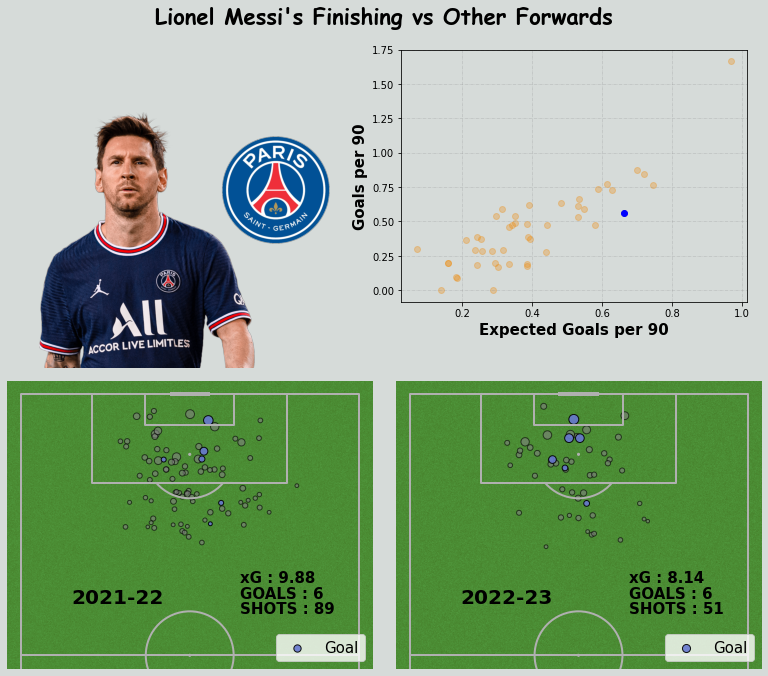

In [64]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background)

#SETTING UP THE MPL AXIS FOR THE FIRST SEASON
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta',line_zorder=3,pitch_color='grass')
ax_opta1 = fig.add_axes((0.05, 0.06, 0.45, 0.4))
df_fil = draw_pitch(pitch,ax_opta1,2021)

# DOING THE SAME FOR THE SECOND SEASON TOO
ax_opta2 = fig.add_axes((0.50, 0.06, 0.45, 0.4))
df_fil = draw_pitch(pitch,ax_opta2,2022)

# NOW PLOTTING THE SCATTERPLOT
ax_scatter = fig.add_axes([0.52,0.57,0.4,0.35])
ax_scatter.patch.set_facecolor(background)

# SETTING UP THE X AND Y OF THE SCATTERPLOT
no_90s = 10
df_fil = df_fbref[df_fbref['90s']>=no_90s]
df_fil = df_fil[df_fil['Pos'].apply(lambda x: x in ['FW','MF,FW','FW,MF'])]
x,y = (df_fil['xG']/df_fil['90s']).to_list(), (df_fil['Gls']/df_fil['90s']).to_list()
ax_scatter.scatter(x,y,alpha=0.3,c='#EF8804')

# NOW FILTERING MESSI'S DATA
df_player = df_fil[df_fil['Player']=='Lionel Messi']
ax_scatter.scatter(df_player['xG']/df_player['90s'], df_player['Gls']/df_player['90s'], c='blue')

ax_scatter.grid(visible = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)
ax_scatter.set_xlabel('Expected Goals per 90', fontdict = {'fontsize':15, 'weight' : 'bold', 'color':text_color})
ax_scatter.set_ylabel('Goals per 90', fontdict = dict(fontsize = 15, weight = 'bold',color=text_color))

#ADDING MESSI'S IMAGE
ax_player = fig.add_axes([0.1,0.43,0.25,0.45])
ax_player.axis('off')
im = plt.imread('images/messi.png')
ax_player.imshow(im)

# ADDING CLUB LOGO
ax_team = fig.add_axes([0.3,0.65,0.15,0.15])
ax_team.axis('off')
im = plt.imread('images/psg.png')
ax_team.imshow(im)

fig.suptitle("Lionel Messi's Finishing vs Other Forwards",fontweight = "bold",fontsize=22, fontname="Cursive")
fig.tight_layout(pad=8.0)
